In [2]:
%cd drive/MyDrive/Colab\ Notebooks/NSI

/content/drive/MyDrive/Colab Notebooks/NSI


In [ ]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import math, copy, time
from typing import NoReturn, Optional, Callable, Generator, Iterable, List
import matplotlib.pyplot as plt
import seaborn
from collections import OrderedDict
import pickle
import gensim
import sklearn
from AttentionNSI import *

seaborn.set_context(context='talk')
%matplotlib inline

Device

In [ ]:
torch.cuda.is_available()

True

In [ ]:
torch.cuda.current_device()

0

In [ ]:
torch.cuda.device_count()

1

In [ ]:
torch.cuda.get_device_name(0)

'Tesla K80'

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

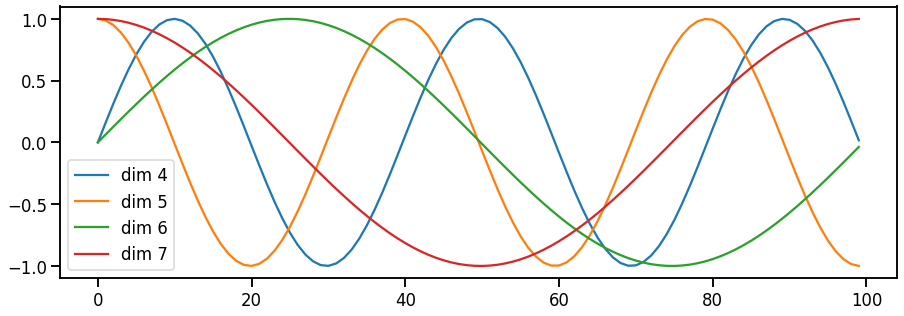

In [ ]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(torch.zeros(1, 100, 20))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend([f'dim {p}' for p in [4, 5, 6, 7]])
None

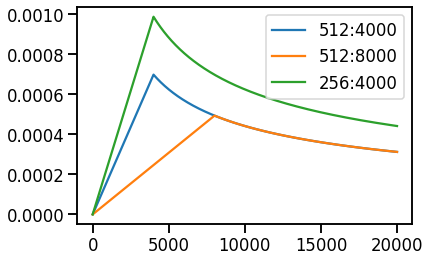

In [ ]:
opts = [NoamOpt(512, 1, 4000, None),
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000),
         [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(['512:4000', '512:8000', '256:4000'])
None

tensor([[0.1000, 0.1000, 0.6000, 0.1000, 0.1000],
        [0.1000, 0.6000, 0.1000, 0.1000, 0.1000],
        [0.6000, 0.1000, 0.1000, 0.1000, 0.1000]])


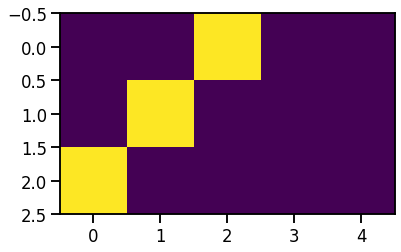

In [ ]:
crit = LabelSmoothing(5, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(predict.log(),
         torch.LongTensor([2, 1, 0]))

plt.imshow(crit.true_dist)
None

print(crit.true_dist)

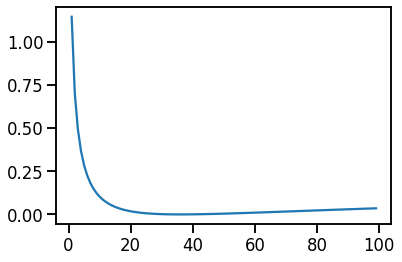

In [ ]:
crit = LabelSmoothing(5, 0.1)
def loss(x):
  d = x + 4 * 1
  predict = torch.FloatTensor([[1 / d, x / d, 1 / d, 1 / d, 1 / d],
                               ])
  return crit(predict.log(),
              torch.LongTensor([1]))
plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])
None

In [ ]:
def get_mask(embedded_sent: np.ndarray, n_seq: int) -> np.ndarray:
  len_sent = embedded_sent.shape[0]
  assert len_sent > 0
  if len_sent > n_seq:
    return np.ones(n_seq)
  else:
    return np.concatenate((np.ones(len_sent), np.zeros(n_seq - len_sent)))

In [ ]:
def pad(embedded_sent: np.ndarray, n_seq: int) -> np.ndarray:
  len_sent = embedded_sent.shape[0]
  assert len_sent > 0
  if len_sent >= n_seq:
    return embedded_sent[:n_seq]
  else:
    return np.concatenate((embedded_sent, np.zeros((n_seq - len_sent, 100))))


Business

In [ ]:
def data_gen(batch: int,
             n_seq: int) -> Iterable[Batch]:
  with open(f'data/cleaned_new_b2_business_labels.pkl', 'rb') as f:
    labs = pickle.load(f)
  #y = F.one_hot(torch.tensor(labs))
  y = torch.tensor(labs).long()

  y_row_start = 0
  for file_num in range(4):
    with open(f'data/embedded_new_b2_business_{file_num}.pkl', 'rb') as f:
      embedded = pickle.load(f)
    i = 0
    rows_in_this_file = len(embedded)
    while (i + 1) * batch < rows_in_this_file:
      src = torch.tensor(
          list(map(lambda embedded_sent: pad(embedded_sent, n_seq),
                   embedded[i * batch:(i + 1) * batch])),
          requires_grad=False).float().to(device)
      src_mask = torch.tensor(
          list(map(lambda embedded_sent: get_mask(embedded_sent, n_seq),
                   embedded[i * batch:(i + 1) * batch]))
          ).float().unsqueeze(-2).requires_grad_(False).to(device)
      trg = y[y_row_start + i * batch:y_row_start + (i + 1) * batch].clone().detach().requires_grad_(False).to(device)
      assert src.shape[0] == trg.shape[0]
      yield Batch(src, src_mask, trg)
      i += 1

    src = torch.tensor(
        list(map(lambda embedded_sent: pad(embedded_sent, n_seq),
                  embedded[i * batch:])),
        requires_grad=False).float().to(device)
    src_mask = torch.tensor(
        list(map(lambda embedded_sent: get_mask(embedded_sent, n_seq),
                  embedded[i * batch:]))
        ).float().unsqueeze(-2).requires_grad_(False).to(device)
    trg = y[y_row_start + i * batch:y_row_start + rows_in_this_file].clone().detach().requires_grad_(False).to(device)
    assert src.shape[0] == trg.shape[0]
    yield Batch(src, src_mask, trg)

    y_row_start += rows_in_this_file

In [ ]:
def validation_data_gen(batch: int, n_seq: int) -> Iterable[Batch]:
  with open(f'data/cleaned_new_b1_business_labels.pkl', 'rb') as f:
    labs = pickle.load(f)
  #y = F.one_hot(torch.tensor(labs))
  y = torch.tensor(labs).long()

  y_row_start = 4 * 64000
  for file_num in range(4, 5):
    with open(f'data/embedded_new_b1_business_{file_num}.pkl', 'rb') as f:
      embedded = pickle.load(f)
    i = 0
    rows_in_this_file = len(embedded)
    while (i + 1) * batch < rows_in_this_file:
      src = torch.tensor(
          list(map(lambda embedded_sent: pad(embedded_sent, n_seq),
                   embedded[i * batch:(i + 1) * batch])),
          requires_grad=False).float().to(device)
      src_mask = torch.tensor(
          list(map(lambda embedded_sent: get_mask(embedded_sent, n_seq),
                   embedded[i * batch:(i + 1) * batch]))
          ).float().unsqueeze(-2).requires_grad_(False).to(device)
      trg = y[y_row_start + i * batch:y_row_start + (i + 1) * batch].clone().detach().requires_grad_(False).to(device)
      assert src.shape[0] == trg.shape[0]
      yield Batch(src, src_mask, trg)
      i += 1

    src = torch.tensor(
        list(map(lambda embedded_sent: pad(embedded_sent, n_seq),
                  embedded[i * batch:])),
        requires_grad=False).float().to(device)
    src_mask = torch.tensor(
        list(map(lambda embedded_sent: get_mask(embedded_sent, n_seq),
                  embedded[i * batch:]))
        ).float().unsqueeze(-2).requires_grad_(False).to(device)
    trg = y[y_row_start + i * batch:y_row_start + rows_in_this_file].clone().detach().requires_grad_(False).to(device)
    assert src.shape[0] == trg.shape[0]
    yield Batch(src, src_mask, trg)

    y_row_start += rows_in_this_file

In [ ]:
#criterion = nn.MSELoss()
#criterion = nn.NLLLoss()
criterion = LabelSmoothing(size=3, smoothing=0.2)

model = make_model(N=2, d_model=100, n_seq=32, d_ff=400, d_ff2=400, n_classes=3, h=2).to(device)
model_opt = NoamOpt(100, 1, 400,
                    torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(5):
  model.train()
  run_epoch(data_gen(64, 32), model,
            SimpleLossCompute(criterion, model_opt))
  print('Start Validation')
  model.eval()
  val_loss = run_epoch(validation_data_gen(64, 32), model,
                       SimpleLossCompute(criterion, None))
  print(f'{epoch} Epoch Validation Loss: {val_loss}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


Epoch Step: 1 Loss: 0.03861447796225548, Tokens per Sec: 345.1295166015625
Epoch Step: 51 Loss: 0.020059827715158463, Tokens per Sec: 38405.39453125
Epoch Step: 101 Loss: 0.009880632162094116, Tokens per Sec: 38909.62890625
Epoch Step: 151 Loss: 0.011499454267323017, Tokens per Sec: 39628.2421875
Epoch Step: 201 Loss: 0.00856368150562048, Tokens per Sec: 38038.98046875
Epoch Step: 251 Loss: 0.006727525964379311, Tokens per Sec: 24564.173828125
Epoch Step: 301 Loss: 0.00949733518064022, Tokens per Sec: 39034.9921875
Epoch Step: 351 Loss: 0.009735466912388802, Tokens per Sec: 39112.03515625
Epoch Step: 401 Loss: 0.007573101669549942, Tokens per Sec: 32489.001953125
Epoch Step: 451 Loss: 0.009326569736003876, Tokens per Sec: 24034.078125
Epoch Step: 501 Loss: 0.00682342192158103, Tokens per Sec: 14742.1923828125
Epoch Step: 551 Loss: 0.005973091349005699, Tokens per Sec: 27447.52734375
Epoch Step: 601 Loss: 0.00582761038094759, Tokens per Sec: 38449.74609375
Epoch Step: 651 Loss: 0.009313

In [ ]:
model_path = 'data/attention_nsi_new_b2_5epoch_label_smoothing_cuda.model'
torch.save(model.state_dict(), model_path)

In [ ]:
model_path = 'data/attention_nsi_384000_sent_5epoch_labe_smoothing_cuda.model'
model = make_model(N=2, d_model=100, n_seq=32, d_ff=400, d_ff2=400, n_classes=3, h=2)
model.load_state_dict(torch.load(model_path, map_location=device))

Validation

In [22]:
batch = 64
n_seq = 32

model.eval()

with open(f'data/cleaned_new_b2_business_labels.pkl', 'rb') as f:
  labs = pickle.load(f)

y_true = labs[64000 * 4:64000 * 4 + 12800]
preds = []
with open('data/embedded_new_b2_business_4.pkl', 'rb') as f:
  embedded = pickle.load(f)
i = 0
#rows_in_this_file = len(embedded)
rows_in_this_file = 12800
while (i + 1) * batch < rows_in_this_file:
  src = torch.tensor(
      list(map(lambda embedded_sent: pad(embedded_sent, n_seq),
                embedded[i * batch:(i + 1) * batch])),
      requires_grad=False).float().to(device)
  src_mask = torch.tensor(
      list(map(lambda embedded_sent: get_mask(embedded_sent, n_seq),
                embedded[i * batch:(i + 1) * batch]))
      ).float().unsqueeze(-2).requires_grad_(False).to(device)
  preds.append(model.forward(src, src_mask))
  i += 1

src = torch.tensor(
    list(map(lambda embedded_sent: pad(embedded_sent, n_seq),
              embedded[i * batch:rows_in_this_file])),
    requires_grad=False).float().to(device)
src_mask = torch.tensor(
    list(map(lambda embedded_sent: get_mask(embedded_sent, n_seq),
              embedded[i * batch:rows_in_this_file]))
    ).float().unsqueeze(-2).requires_grad_(False).to(device)
preds.append(model.forward(src, src_mask))

y_pred = torch.concat(preds)

In [23]:
len(y_pred)

12800

In [24]:
labs_pred = torch.argmax(y_pred.to(torch.device('cpu')), dim=1)

In [25]:
labs_pred

tensor([2, 0, 2,  ..., 0, 2, 0])

In [26]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [27]:
confusion_matrix(y_true, labs_pred).T

array([[9735,  725,  775],
       [ 215,  393,    8],
       [ 330,   46,  573]])

In [28]:
accuracy_score(y_true, labs_pred)

0.836015625

In [29]:
#for cleaning memory
y_pred = 0
embedded = 0

Domestic

In [30]:
def data_gen(batch: int,
             n_seq: int) -> Iterable[Batch]:
  with open(f'data/cleaned_new_b2_domestic_labels.pkl', 'rb') as f:
    labs = pickle.load(f)
  #y = F.one_hot(torch.tensor(labs))
  y = torch.tensor(labs).long()

  y_row_start = 0
  for file_num in range(3):
    with open(f'data/embedded_new_b2_domestic_{file_num}.pkl', 'rb') as f:
      embedded = pickle.load(f)
    i = 0
    rows_in_this_file = len(embedded)
    while (i + 1) * batch < rows_in_this_file:
      src = torch.tensor(
          list(map(lambda embedded_sent: pad(embedded_sent, n_seq),
                   embedded[i * batch:(i + 1) * batch])),
          requires_grad=False).float().to(device)
      src_mask = torch.tensor(
          list(map(lambda embedded_sent: get_mask(embedded_sent, n_seq),
                   embedded[i * batch:(i + 1) * batch]))
          ).float().unsqueeze(-2).requires_grad_(False).to(device)
      trg = y[y_row_start + i * batch:y_row_start + (i + 1) * batch].clone().detach().requires_grad_(False).to(device)
      assert src.shape[0] == trg.shape[0]
      yield Batch(src, src_mask, trg)
      i += 1

    src = torch.tensor(
        list(map(lambda embedded_sent: pad(embedded_sent, n_seq),
                  embedded[i * batch:])),
        requires_grad=False).float().to(device)
    src_mask = torch.tensor(
        list(map(lambda embedded_sent: get_mask(embedded_sent, n_seq),
                  embedded[i * batch:]))
        ).float().unsqueeze(-2).requires_grad_(False).to(device)
    trg = y[y_row_start + i * batch:y_row_start + rows_in_this_file].clone().detach().requires_grad_(False).to(device)
    assert src.shape[0] == trg.shape[0]
    yield Batch(src, src_mask, trg)

    y_row_start += rows_in_this_file

In [31]:
def validation_data_gen(batch: int, n_seq: int) -> Iterable[Batch]:
  with open(f'data/cleaned_new_b2_domestic_labels.pkl', 'rb') as f:
    labs = pickle.load(f)
  #y = F.one_hot(torch.tensor(labs))
  y = torch.tensor(labs).long()

  y_row_start = 3 * 64000
  for file_num in range(3, 4):
    with open(f'data/embedded_new_b2_domestic_{file_num}.pkl', 'rb') as f:
      embedded = pickle.load(f)
    i = 0
    rows_in_this_file = len(embedded)
    while (i + 1) * batch < rows_in_this_file:
      src = torch.tensor(
          list(map(lambda embedded_sent: pad(embedded_sent, n_seq),
                   embedded[i * batch:(i + 1) * batch])),
          requires_grad=False).float().to(device)
      src_mask = torch.tensor(
          list(map(lambda embedded_sent: get_mask(embedded_sent, n_seq),
                   embedded[i * batch:(i + 1) * batch]))
          ).float().unsqueeze(-2).requires_grad_(False).to(device)
      trg = y[y_row_start + i * batch:y_row_start + (i + 1) * batch].clone().detach().requires_grad_(False).to(device)
      assert src.shape[0] == trg.shape[0]
      yield Batch(src, src_mask, trg)
      i += 1

    src = torch.tensor(
        list(map(lambda embedded_sent: pad(embedded_sent, n_seq),
                  embedded[i * batch:])),
        requires_grad=False).float().to(device)
    src_mask = torch.tensor(
        list(map(lambda embedded_sent: get_mask(embedded_sent, n_seq),
                  embedded[i * batch:]))
        ).float().unsqueeze(-2).requires_grad_(False).to(device)
    trg = y[y_row_start + i * batch:y_row_start + rows_in_this_file].clone().detach().requires_grad_(False).to(device)
    assert src.shape[0] == trg.shape[0]
    yield Batch(src, src_mask, trg)

    y_row_start += rows_in_this_file

In [32]:
#criterion = nn.MSELoss()
#criterion = nn.NLLLoss()
criterion = LabelSmoothing(size=3, smoothing=0.2)

model = make_model(N=2, d_model=100, n_seq=32, d_ff=400, d_ff2=400, n_classes=3, h=2).to(device)
model_opt = NoamOpt(100, 1, 400,
                    torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(5):
  model.train()
  run_epoch(data_gen(64, 32), model,
            SimpleLossCompute(criterion, model_opt))
  print('Start Validation')
  model.eval()
  val_loss = run_epoch(validation_data_gen(64, 32), model,
                       SimpleLossCompute(criterion, None))
  print(f'{epoch} Epoch Validation Loss: {val_loss}')

Epoch Step: 1 Loss: 0.05841228738427162, Tokens per Sec: 330.4421081542969
Epoch Step: 51 Loss: 0.014174968004226685, Tokens per Sec: 38901.85546875
Epoch Step: 101 Loss: 0.015553458593785763, Tokens per Sec: 39270.91796875
Epoch Step: 151 Loss: 0.012234574183821678, Tokens per Sec: 39800.08984375
Epoch Step: 201 Loss: 0.011555008590221405, Tokens per Sec: 39922.28125
Epoch Step: 251 Loss: 0.008777273818850517, Tokens per Sec: 39678.96484375
Epoch Step: 301 Loss: 0.01054514478892088, Tokens per Sec: 40113.8359375
Epoch Step: 351 Loss: 0.01001731026917696, Tokens per Sec: 38527.73828125
Epoch Step: 401 Loss: 0.011919752694666386, Tokens per Sec: 38663.01171875
Epoch Step: 451 Loss: 0.0107008321210742, Tokens per Sec: 39928.16015625
Epoch Step: 501 Loss: 0.006992944981902838, Tokens per Sec: 39103.22265625
Epoch Step: 551 Loss: 0.009229252114892006, Tokens per Sec: 24633.716796875
Epoch Step: 601 Loss: 0.01247586403042078, Tokens per Sec: 39262.38671875
Epoch Step: 651 Loss: 0.0094353174

In [33]:
model_path = 'data/attention_nsi_new_b2_5epoch_label_smoothing_cuda_domestic.model'
torch.save(model.state_dict(), model_path)

In [1]:
!git status

fatal: not a git repository (or any of the parent directories): .git
